**Image Blending**

**Ahmed Malik || July 2020**

In [2]:
# Setup matplotlib
import matplotlib
import matplotlib.pyplot as plt
import PyQt5

# Use this line below to set a backend for matplotlib
matplotlib.use('Qt5Agg')

In [3]:
# Import necessary packages
import gc
import os
import sys
import math
import glob
import numpy as np
import skimage as sk
import skimage.transform
import skimage.io as skio
import skimage.draw as skdraw
import scipy
import scipy.spatial
from tqdm.auto import trange

# Set plotting style using seaborn
import seaborn as sns
# sns.reset_orig()
sns.set(style="white", color_codes=True, font_scale=1.22)

In [4]:
# Functions defined to make life easier...

def readImg(imname, float32=1):
    """
    Read in an image using skimage.
    
    Parameters
    ----------
    imname : string
        path to image file
    float32 : bool (1 or 0)
        determines whether to read image as float32; default is 1
        
    Returns
    -------
    im : np.ndarray
        image read by skimage; ready to show using plt.imshow()
    """
    if float32:
        im = skio.imread(imname)
        im = sk.img_as_float32(im)
        return im
    else:
        im = skio.imread(imname)
        return im
    
def get_points(img, num_pts=20, figsize=(15,10)):
    """
    Function used to get correspondence points. Make sure the top of the cell using this
    function has the line %matplotlib qt.
    
    Parameters
    ----------
    img : np.ndarray
        Image to get correspondence points from
    num_pts : int
        Number of correspondence points to get; default=20
    figsize : tuple
        Allows user to specify figure size; default=(15,10)
    
    Returns
    -------
    corr_pts : np.ndarray
        Points of correspondence
    """
    plt.figure(figsize=figsize)
    plt.imshow(img)
    corr_pts = plt.ginput(num_pts, timeout=0)
    # Specify corner points of image!
    corr_pts += [(0,0), (0,img.shape[0]-1), (img.shape[1]-1,0), (img.shape[1]-1,img.shape[0]-1)]
    plt.close()
    corr_pts = np.array(corr_pts)
    return corr_pts

def plot_corr_pts(img, corr_pts, figsize=(15,10), cmap=None, c='k', save=False, save_dst=None):
    """
    Plots the correspondence points on top of image. Useful for visualization and debugging.
    
    Parameters
    ----------
    img : np.ndarray
        Image on top of which correspondence points will be overlayed
    corr_pts : np.ndarray
        Points of correspondence to overlay
    figsize : tuple
        Allows user to specify figure size; default=(15,10)
    save : bool
        Specifies whether or not to save image; default=False
    save_dst : str
        Specfies where to save image; default=None
    
    Returns
    -------
    None, just plots
    """
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img, cmap=cmap)
    plt.scatter(corr_pts[:,0], corr_pts[:,1], s=100, c=c, marker='x')
    if save:
        plt.savefig(save_dst)
    plt.show()
    
def get_mean_corr(corr_pts1, corr_pts2):
    """
    Gets the average points of correspondence to be used in Delaunay triangulation for
    mid-way shape.
    
    Parameters
    ----------
    corr_pts1 : np.ndarray
        Correspondence points of first image
    corr_pts2 : np.ndarray
        Correspondence points of second image
        
    Returns
    -------
    mean_corr : np.ndarray
        Arithmetic mean (average) of input correspondence points
    """
    mean_corr = (corr_pts1+corr_pts2)/2
    return mean_corr

def computeAffine(tri1_pts, tri2_pts):
    """
    Computes the affine transformation matrix A between two triangles
    
    Parameters
    ----------
    tri1_pts : np.ndarray
        Coordinates of triangle for first image's set of triangles
    tri2_pts : np.ndarray
        Coordinates of triangle for second image's (usually average shape) set of triangles
    
    Returns
    -------
    T : np.ndarray
        Inverse affine transformation matrix between the two triangles
    """
    A = np.array([tri1_pts[:,0],
                  tri1_pts[:,1],
                  [1, 1, 1]])
    A_inv = np.linalg.inv(A)
    X = np.array([tri2_pts[:,0],
                  tri2_pts[:,1],
                  [1, 1, 1]])
    T = np.linalg.inv(np.dot(X, A_inv))
    return T

def transform_triangles(img, corr_pts, mean_pts, tri_pts, color=True):
    """
    Transforms triangles from first image to average shape.
    
    Parameters
    ----------
    img : np.ndarray
        Image on which transform will take place
    corr_pts : np.ndarray
        Points of correspondence associated with img
    mean_pts : np.ndarray
        Points of correspondence for average shape of first img and second img
    tri_pts : np.ndarray
        Vertices of triangles from Delaunay transformation
    color : bool
        Handles grayscale images if set to False; default=True
        
    Returns
    -------
    new_img : np.ndarray
        Input img pixels transformed to mean shape image pixels locations
    """
    new_img = np.zeros(img.shape)
    for i in range(len(tri_pts)):
        tri1_pts = np.array([corr_pts[tri_pts[i][0]],
                             corr_pts[tri_pts[i][1]],
                             corr_pts[tri_pts[i][2]]])
        tri2_pts = np.array([mean_pts[tri_pts[i][0]],
                             mean_pts[tri_pts[i][1]],
                             mean_pts[tri_pts[i][2]]])
        A = computeAffine(tri1_pts, tri2_pts)
        pts_in_tri2 = skdraw.polygon(tri2_pts[:,0], tri2_pts[:,1])
        M = np.stack((pts_in_tri2[0], pts_in_tri2[1], np.ones(len(pts_in_tri2[0]))))
        # corresponding points in img, using inverse from mid
        tri2_pts_transformed = np.dot(A, M).astype(int)
        # Clip values that are out of range of img shape
        tri2_pts_transformed[0,:] = tri2_pts_transformed[0,:]%img.shape[1]
        tri2_pts_transformed[1,:] = tri2_pts_transformed[1,:]%img.shape[0]
        if color:
            super_threshold_indices = tri2_pts_transformed[1] > 3152
            tri2_pts_transformed[1][super_threshold_indices] = 3152
            super_threshold_indices = tri2_pts_transformed[0] > 2497
            tri2_pts_transformed[0][super_threshold_indices] = 2497
            new_img[pts_in_tri2[1], pts_in_tri2[0], :] = img[tri2_pts_transformed[1],
                                                             tri2_pts_transformed[0], :]
        elif not color:
            new_img[pts_in_tri2[1], pts_in_tri2[0]] = img[tri2_pts_transformed[1],
                                                          tri2_pts_transformed[0]]
    return new_img

def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    """
    Produces a warp between im1 and im2 using the correspondence points im1_pts and im2_pts and
    the vertices produced from Delaunay triangulation.
    
    Parameters
    ----------
    im1 : np.ndarray
        Starting image in morph sequence
    im2 : np.ndarray
        Ending image in morph sequence
    im1_pts : np.ndarray
        Correspondence points of starting image
    im2_pts : np.ndarray
        Correspondence points of ending image
    tri : np.ndarray
        Vertices of triangulations obtained from Delaunay triangulation
    warp_frac : float
        Controls shape warping
    dissolve_frac : float
        Controls cross-dissolve
        
    Returns
    -------
    morphed_img : np.ndarray
        im1 morphed to im2 using warp_frac and dissolve_frac
        
    ValueError: operands could not be broadcast together with shapes (3159,2506,3) (3153,2498,3)
    """
    avg_shape = im1_pts+warp_frac*(im2_pts-im1_pts)
    img1_transformed = transform_triangles(im1, im1_pts, avg_shape, tri)
    img2_transformed = transform_triangles(im2, im2_pts, avg_shape, tri)
    morphed_img = img1_transformed + (dissolve_frac*(img2_transformed-img1_transformed))
    return morphed_img

def morph_sequence(im1, im2, im1_pts, im2_pts, tri, num_frames=45, display=False):
    """
    Produce frames of morph sequence. Frames are saved as .png files in the out directory.
    To produce a .gif or animation, please use an online tool such as gifmaker.me.
    
    Parameters
    ----------
    im1 : np.ndarray
        Starting image in morph sequence
    im2 : np.ndarray
        Ending image in morph sequence
    im1_pts : np.ndarray
        Correspondence points of starting image
    im2_pts : np.ndarray
        Correspondence points of ending image
    tri : np.ndarray
        Vertices of triangulations obtained from Delaunay triangulation
    num_frames : int
        Number of frames to produce, zero-indexed; default=45 (so 46 total frames)
    display : bool
        Specifies whether individual frames should be displayed in the notebook; default=False
        
    Returns
    -------
    None, just plots and/or saves frames
    """
    for i in range(0,num_frames+1):
        print(f'Morph #{i+1}')
        warp_frac = i/num_frames
        dissolve_frac = i/num_frames
        morphed_img = morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac)
        plt.figure(figsize=(15,10))
        plt.imshow(morphed_img)
        plt.axis('off')
        plt.savefig(f'out/morphed_frame_{i}.png')
        if not display:
            plt.close()
    print("Morphing complete! See all frames in /out folder.")

In [5]:
import cv2
import numpy as np

def resizeAndPad(img, size, padColor=0):
    """
    Function to resize image to destination size and pad accordingly. Taken directly from:
    https://stackoverflow.com/questions/44720580/resize-image-canvas-to-maintain-square-aspect-ratio-in-python-opencv
    """

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

**Computing the Mid-way Face & Morph Sequence**
---

Place the images you would like to use in the **images/** folder. Make sure the first image is named _src.jpg_ and the second image is named _dst.jpg_.

In [6]:
# Read in images and get respective shapes
src = readImg('images/src.jpg')
src_shape = src.shape
dst = readImg('images/dst.jpg')
dst_shape = dst.shape
# Assert that they have the same colorspace (RGB, B&W, etc.)
assert src_shape[2]==dst_shape[2], "ERROR: One image has a different color space than the other!"
# Make sure they're the same size!!
mutual_shape = (min(src_shape[0], dst_shape[0]), min(src_shape[1], dst_shape[1]), 3)
src = src[:mutual_shape[0], :mutual_shape[1], :mutual_shape[2]]
dst = dst[:mutual_shape[0], :mutual_shape[1], :mutual_shape[2]]

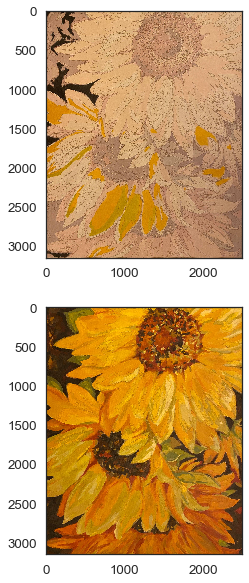

In [7]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, figsize=(15,10))
ax[0].imshow(src)
ax[1].imshow(dst)

In the below 2 cells, there are 2 sections: FIRST PASS and SECOND OR LATER PASS.
<br><br>
#### FIRST PASS
This section is used to select 24 points of correspondence between your first image and your second image. After you make your correspondences, it saves your points in a .txt file within the saved_points folder so that you don't have to click and select these points every time for images you have already completed this process for.

When selecting points of correspondence, make sure you remember which points of interest you're selecting in the first image so that you can repeat this for the second image. For example, if your first point if the inner pupil of the left eye in your first image, make sure it is the same for the second image too. Not doing so can produce strange/interesting results, or may also just break the code.

Also, try to avoid points towards the edges of the images.
<br><br>
#### SECOND PASS
If you already have your points of correspondences saved, simply input which .txt file you would like to load so you don't have to redo the correspondence process.

In [8]:
# FIRST PASS
# %matplotlib qt
# src_pts = get_points(src, num_pts=24)
# src_pts_str = input("Save these points with a descriptive name for future use (add .txt at the end): ")
# src_pts_loc = f'saved_points/{src_pts_str}'
# np.savetxt(src_pts_loc, src_pts)

# SECOND OR LATER PASS
print("See files in save")
src_pts_str = input("Which .txt file would you like to load for your src image (add the .txt extension at the end)?: ")
src_pts_loc = f'saved_points/{src_pts_str}'
src_pts = np.loadtxt(src_pts_loc)

Which .txt file would you like to load for your src image (add the .txt extension at the end)?: flower_src.txt


In [9]:
# FIRST PASS
# %matplotlib qt
# dst_pts = get_points(dst, num_pts=24)
# dst_pts_str = input("Save these points with a descriptive name for future use (add .txt at the end): ")
# dst_pts_loc = f'saved_points/{dst_pts_str}'
# np.savetxt(dst_pts_loc, dst_pts)

# SECOND OR LATER PASS
dst_pts_str = input("Which .txt file would you like to load for your dst image (add the .txt extension at the end)?: ")
dst_pts_loc = f'saved_points/{dst_pts_str}'
dst_pts = np.loadtxt(dst_pts_loc)

Which .txt file would you like to load for your dst image (add the .txt extension at the end)?: flower_dst.txt


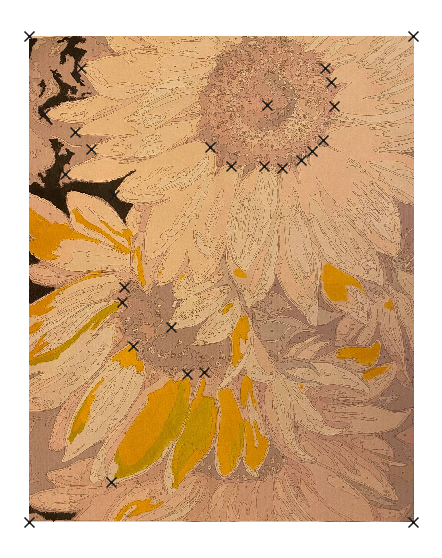

In [10]:
%matplotlib inline
plot_corr_pts(src, src_pts, save=False)

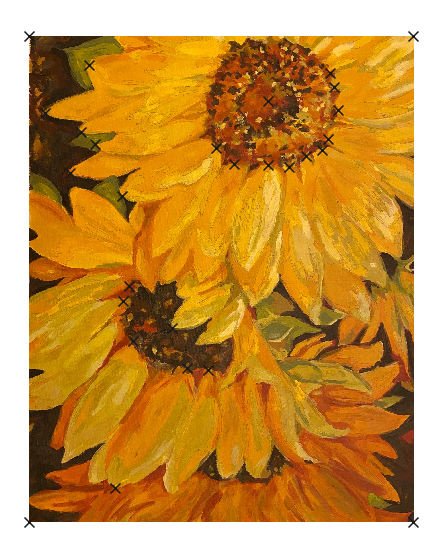

In [11]:
%matplotlib inline
plot_corr_pts(dst, dst_pts, save=False)

In [12]:
src_dst_avg = get_mean_corr(src_pts, dst_pts)

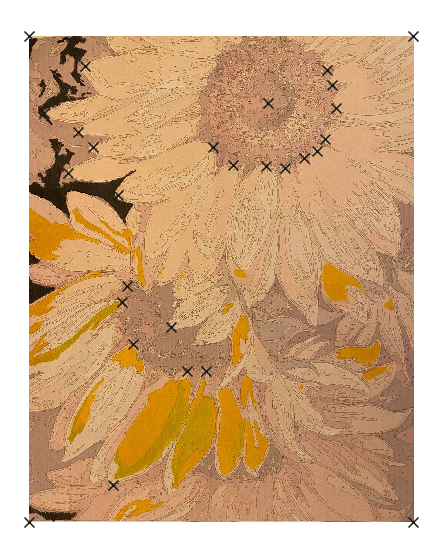

In [13]:
plot_corr_pts(src, src_dst_avg)

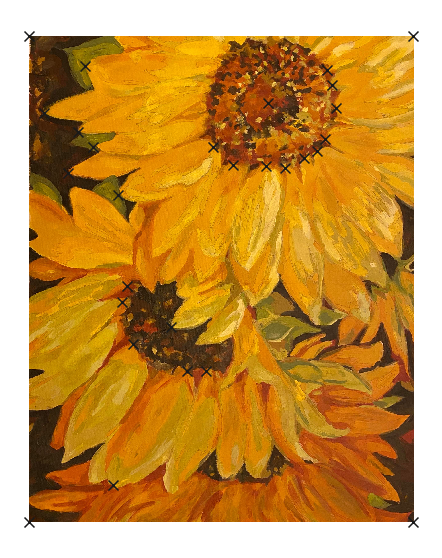

In [14]:
plot_corr_pts(dst, src_dst_avg)

In [15]:
delaunay_tris = scipy.spatial.Delaunay(src_dst_avg)
tri_pts = delaunay_tris.simplices.copy()

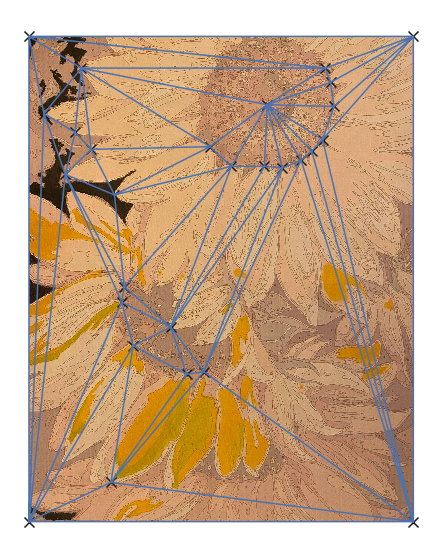

In [16]:
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(src)
plt.triplot(src_pts[:,0], src_pts[:,1], tri_pts)
plt.scatter(src_pts[:,0], src_pts[:,1], s=100, c='k', marker='x')

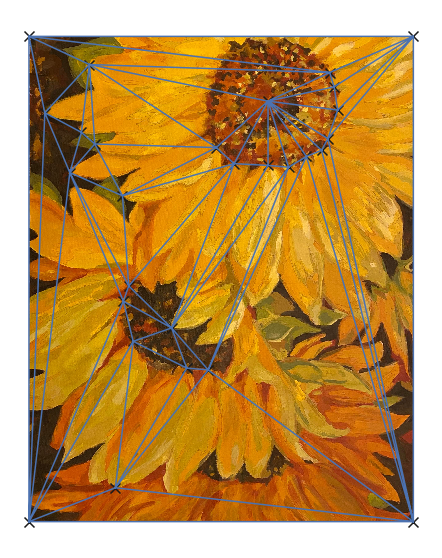

In [17]:
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(dst)
plt.triplot(dst_pts[:,0], dst_pts[:,1], tri_pts)
plt.scatter(dst_pts[:,0], dst_pts[:,1], s=100, c='k', marker='x')

This is the function that handles the actual morphing, by creating frames for the resultant .gif or animation video. It creates 46 frames (#0 - #45). The output from this function is each individual frame and these are located located in the **out/** folder. To create an animation, upload the frame images to an online gifmaker like [gifmaker.me](https://gifmaker.me/) This function has 2 issues:
<br><br>
#### Issue 1:
Sometimes, the kernel dies when running this before producing all 46 frames. If this happens, you can restart the kernel and try again. It usually gets at least 35 frames completed, and closer to 46, but also depends on the image. This seems to be caused by poor memory handling, so a computer with more RAM and disk space should not see this issue.

#### Issue 2:
More seriously, sometimes the code will error out due to the correspondence points manually selected earlier. If this happens, you will need to go back and select new/different correspondence points and try again. There is no real way of knowing whether the points you've selected will solve the issue, but new points usually do. Try to avoid the edges of the image.

In [18]:
morph_sequence(src, dst, src_pts, dst_pts, tri_pts)

Morph #1
Morph #2
Morph #3
Morph #4
Morph #5
Morph #6
Morph #7
Morph #8
Morph #9
Morph #10
Morph #11
Morph #12
Morph #13
Morph #14
Morph #15
Morph #16
Morph #17
Morph #18
Morph #19
Morph #20
Morph #21
Morph #22
Morph #23
Morph #24
Morph #25
Morph #26
Morph #27
Morph #28
Morph #29
Morph #30
Morph #31
Morph #32
Morph #33
Morph #34
Morph #35
Morph #36
Morph #37
Morph #38
Morph #39
Morph #40
Morph #41
Morph #42
Morph #43
Morph #44
Morph #45
Morph #46
Morphing complete! See all frames in /out folder.
